# import

In [188]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [189]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [190]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [191]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Предобработка

In [193]:
def date_replace(line):
    '''
    Функция потребуется для вытягивания данных формата даты.
    '''
    a = pattern.findall(line)
    return a

def price_mapping(symbol):
    '''
    Функция потребуется для "оцифрования" категориального признака Price Range, где 1- самая низкая цена, 3 - самая высокая.
    '''
    if symbol == '$':
        return 1
    elif symbol == '$$ - $$$':
        return 2
    elif symbol == '$$$$':
        return 3
    
def vegetarian_or_not(row):
    '''
    Функция потребуется для создания нового признака "Наличие вегетарианской кухни".
    '''
    if 'Vegetarian Friendly' not in row:
        return 1
    else:
        return 0

# Анализ признаков

**1. **City****

В данном признаке нет пропусков. Посмотрим распределение признака. 

In [194]:
df['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

Применим метод get_dummies для "оцифрования" городов.

In [195]:
df = pd.get_dummies(df, columns=['City',], dummy_na=True)

**2. Reviews**

In [196]:
# зададим патерн для вытягивания дат из колонки "Reviews"
pattern = re.compile('\d\d\S\d\d\S\d\d\d\d')
# применим функцию date_replace чтобы избавиться от текстовой части данных и оставить числовую.
df["Reviews"] = df["Reviews"].apply(date_replace)

In [197]:
# разобьем даты на "ранние" и "поздние" чтобы потом сформировать новый признак date_dif "кол-во дней между первым и последним отзывом"
df['data_first'] = df['Reviews'].apply(lambda x: pd.to_datetime(x).min())
df['data_last'] = df['Reviews'].apply(lambda x: pd.to_datetime(x).max())
df['date_dif'] = df['data_last'] - df['data_first']

**3. Price range**

Посмотрим на распределение признака и пропуски.

In [198]:
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [199]:
# применяем функцию, которая "оцифрует" price range
df['Price Range'] = df['Price Range'].apply(price_mapping)

In [200]:
# пропуски заполним средним значением ценового размаха
df['Price Range'].fillna(round(df['Price Range'].mean()), inplace = True)


**4. Cuisine Style**

Пытаемся определить распределение признака 'Cuisine Style'.

In [201]:
df['Cuisine Style'] = df["Cuisine Style"].fillna('0')
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(x).strip('[]').split(', '))
df = df.explode('Cuisine Style').dropna()
df['Cuisine Style'].value_counts()

'Vegetarian Friendly'    11114
'European'                9510
'Mediterranean'           5903
0                         5593
'Italian'                 5223
                         ...  
'Polynesian'                 1
'Welsh'                      1
'Xinjiang'                   1
'Salvadoran'                 1
'Latvian'                    1
Name: Cuisine Style, Length: 126, dtype: int64

Выглядит так, что наличие вегетарианской кухни является самым популярным значением, остальные значения этого признака отображают географическую принадлежность кухни, что, на мой взгляд, не является существенным признаком для выбора ресторана, поэтому "оцифровываем" только наличие или отсутствие вегетарианской кухни.

In [202]:
df['Vegeterian?'] = df['Cuisine Style'].apply(vegetarian_or_not)

**5. Number of reviews**

Заполним пропуски нулем, полагая, что пропущенные значения в количестве отзывов ознвчает, что отзывов оставлено не было.

In [203]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

# Определение финального набора данных перед его обучением

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94269 entries, 0 to 39999
Data columns (total 45 columns):
Restaurant_id        94269 non-null object
Cuisine Style        94269 non-null object
Ranking              94269 non-null float64
Rating               94269 non-null float64
Price Range          94269 non-null float64
Number of Reviews    94269 non-null float64
Reviews              94269 non-null object
URL_TA               94269 non-null object
ID_TA                94269 non-null object
City_Amsterdam       94269 non-null uint8
City_Athens          94269 non-null uint8
City_Barcelona       94269 non-null uint8
City_Berlin          94269 non-null uint8
City_Bratislava      94269 non-null uint8
City_Brussels        94269 non-null uint8
City_Budapest        94269 non-null uint8
City_Copenhagen      94269 non-null uint8
City_Dublin          94269 non-null uint8
City_Edinburgh       94269 non-null uint8
City_Geneva          94269 non-null uint8
City_Hamburg         94269 non-null ui

Итого: нужно избавиться от пяти признаков со строковыми данными.

In [205]:
df = df.select_dtypes(['number', 'datetime64', 'timedelta64'])
df

,Ranking,Rating,Price Range,Number of Reviews,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,data_first,data_last,date_dif,Vegeterian?
0,5570.0,3.5,2.0,194.0,0,0,0,0,0,0,...,0,0,0,0,0,0,2017-11-20,2017-12-31,41 days,1
0,5570.0,3.5,2.0,194.0,0,0,0,0,0,0,...,0,0,0,0,0,0,2017-11-20,2017-12-31,41 days,1
0,5570.0,3.5,2.0,194.0,0,0,0,0,0,0,...,0,0,0,0,0,0,2017-11-20,2017-12-31,41 days,1
1,1537.0,4.0,2.0,10.0,0,0,0,0,0,0,...,0,1,0,0,0,0,2016-06-19,2017-07-06,382 days,1
2,353.0,4.5,3.0,688.0,0,0,0,0,0,0,...,0,0,0,0,0,0,2018-01-06,2018-01-08,2 days,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39998,641.0,4.0,2.0,70.0,0,0,0,0,0,0,...,0,0,0,1,0,0,2017-06-18,2017-07-11,23 days,1
39998,641.0,4.0,2.0,70.0,0,0,0,0,0,0,...,0,0,0,1,0,0,2017-06-18,2017-07-11,23 days,1
39998,641.0,4.0,2.0,70.0,0,0,0,0,0,0,...,0,0,0,1,0,0,2017-06-18,2017-07-11,23 days,1
39998,641.0,4.0,2.0,70.0,0,0,0,0,0,0,...,0,0,0,1,0,0,2017-06-18,2017-07-11,23 days,0


Теперь нужно сконвертировать данные типа datetime64, timedelta в числовые, для того чтобы они вошли в набор для обучения.

In [206]:
df['data_first'] = df['data_first'].apply(lambda x: x.timestamp())
df['data_last'] = df['data_last'].apply(lambda x: x.timestamp())
df['date_dif'] = df['date_dif'].apply(lambda x: x.total_seconds())

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94269 entries, 0 to 39999
Data columns (total 40 columns):
Ranking              94269 non-null float64
Rating               94269 non-null float64
Price Range          94269 non-null float64
Number of Reviews    94269 non-null float64
City_Amsterdam       94269 non-null uint8
City_Athens          94269 non-null uint8
City_Barcelona       94269 non-null uint8
City_Berlin          94269 non-null uint8
City_Bratislava      94269 non-null uint8
City_Brussels        94269 non-null uint8
City_Budapest        94269 non-null uint8
City_Copenhagen      94269 non-null uint8
City_Dublin          94269 non-null uint8
City_Edinburgh       94269 non-null uint8
City_Geneva          94269 non-null uint8
City_Hamburg         94269 non-null uint8
City_Helsinki        94269 non-null uint8
City_Krakow          94269 non-null uint8
City_Lisbon          94269 non-null uint8
City_Ljubljana       94269 non-null uint8
City_London          94269 non-null uint8
C

# Корреляция числовых переменных

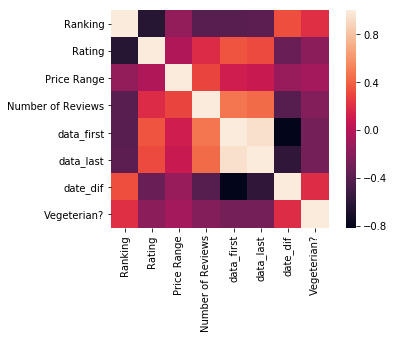

In [208]:
columns_drop = ['City_Amsterdam', 'City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava', 'City_Brussels', 'City_Budapest', 'City_Copenhagen','City_Dublin' ,'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow', 'City_Lisbon', 'City_Ljubljana', 'City_London', 'City_Luxembourg', 'City_Lyon', 'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto', 'City_Oslo', 'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm', 'City_Vienna', 'City_Warsaw', 'City_Zurich', 'City_nan']          
corr = df.corr()
sns.heatmap(corr.drop(columns_drop, axis=1).corr(), square=True)

Самой сильной корреляцией с целевой переменной обладает признак "Ranking".

# Запуск модели

In [209]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

UndefinedVariableError: name 'sample' is not defined

In [ ]:
X = df.drop(['Rating'], axis = 1)  
y = df['Rating']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)